# SAM on cows counting

## Environment

In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
os.chdir("..")
ROOT = os.getcwd()
DIR_DINO = os.path.join(ROOT, "modules", "GroundingDINO")
print("ROOT:", ROOT)

ROOT: /Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_03_Papers/2023/cowsformer


## Install dependencies

In [ ]:
# # https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=CS_WhY60XMNL
# # https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/automated-dataset-annotation-and-evaluation-with-grounding-dino-and-sam.ipynb
# !python -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !python -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [17]:
# os.chdir(os.path.join(ROOT, "models"))
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# os.chdir(os.path.join(ROOT, "models", "GroundingDINO"))
# !git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
# !pip install -q -e .

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


## Import libraries

In [3]:
os.chdir(ROOT)
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from modules.GroundingDINO.groundingdino.util.inference import Model as DinoModel

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('mps')
print(DEVICE)
# SAM
SAM_CHECKPOINT_PATH = os.path.join(ROOT, "models", "sam_vit_h_4b8939.pth")
SAM_ENCODER_VERSION = "vit_h"
# GROUNDING DINO
GROUNDING_DINO_CONFIG_PATH = os.path.join(DIR_DINO,
                                        "groundingdino",
                                        "config", "GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(DIR_DINO, "gdino_swint_ogc.pth")


cpu


## Model

### DINO

In [5]:
grounding_dino_model = DinoModel(model_config_path=GROUNDING_DINO_CONFIG_PATH,
                                 model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
                                 device=DEVICE)

/Users/niche/miniforge3/envs/niche/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### SAM

In [8]:
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Image processing

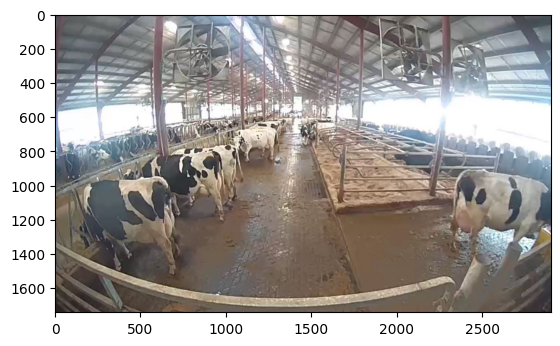

In [9]:
PATH_IMG = os.path.join(ROOT, "data", "cow100", "images", "img_2.jpg")
image_bgr = cv2.imread(PATH_IMG)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

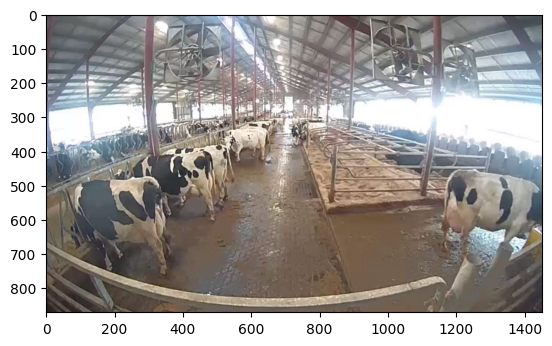

In [12]:
# crop [0:500, 0:1000] and resize to 1000x2000
img_crop = image_rgb
RATE = .5
H, W = img_crop.shape[:2]
NEW_H, NEW_W = int(H * RATE), int(W * RATE)
img_crop = cv2.resize(img_crop, (NEW_W, NEW_H))
plt.imshow(img_crop)

In [ ]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

import cv2
import supervision as sv

# load image
image = img_crop

# detect objects
CLASSES = ['animal']
BOX_TRESHOLD = 0.2 # .35
TEXT_TRESHOLD = 0.1 # .25
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
)

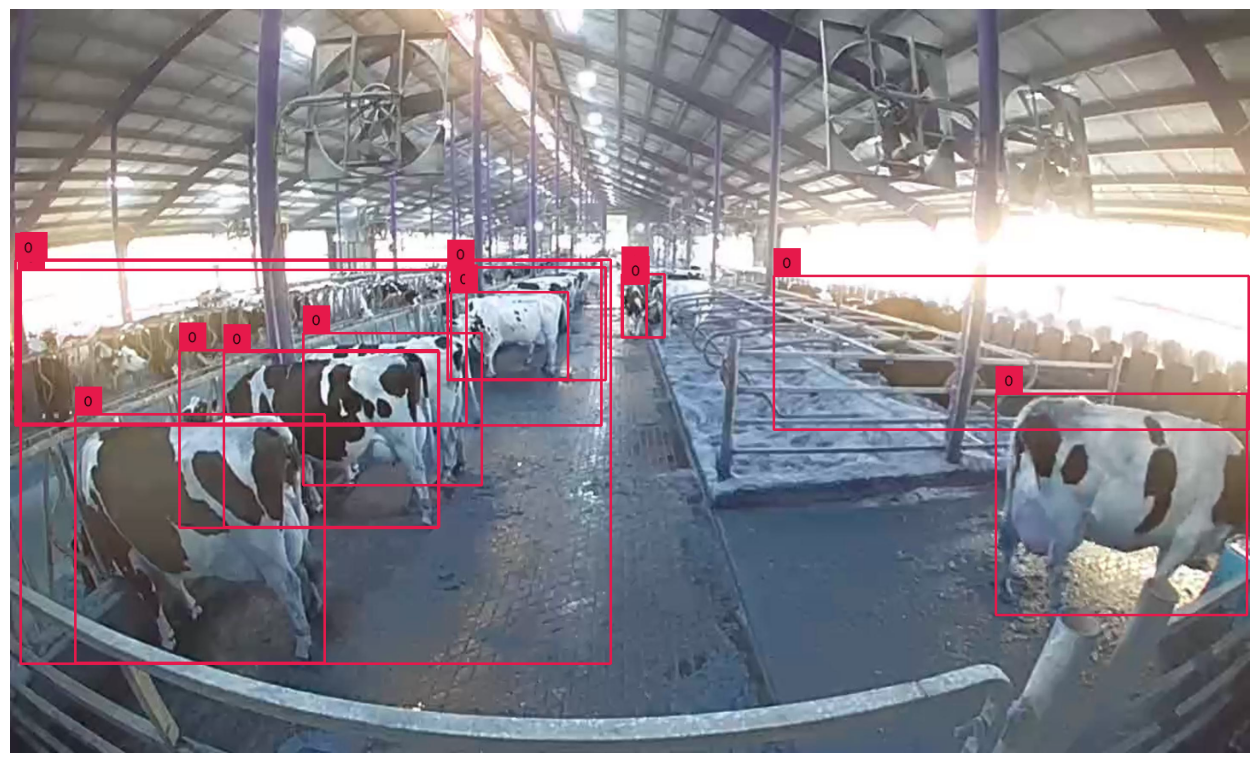

In [27]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
try:
    labels = [
        f"{CLASSES[int(class_id)]} {confidence:0.2f}"
        for bbx, class_id, confidence, track_id
        in detections]
    annotated_frame = box_annotator.annotate(scene=image.copy(),
                                            detections=detections,
                                            labels=labels,
                                            )
except Exception:
    annotated_frame = box_annotator.annotate(scene=image.copy(),
                                            detections=detections,
                                            )


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [21]:
import numpy as np
from segment_anything import SamPredictor
import cv2

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

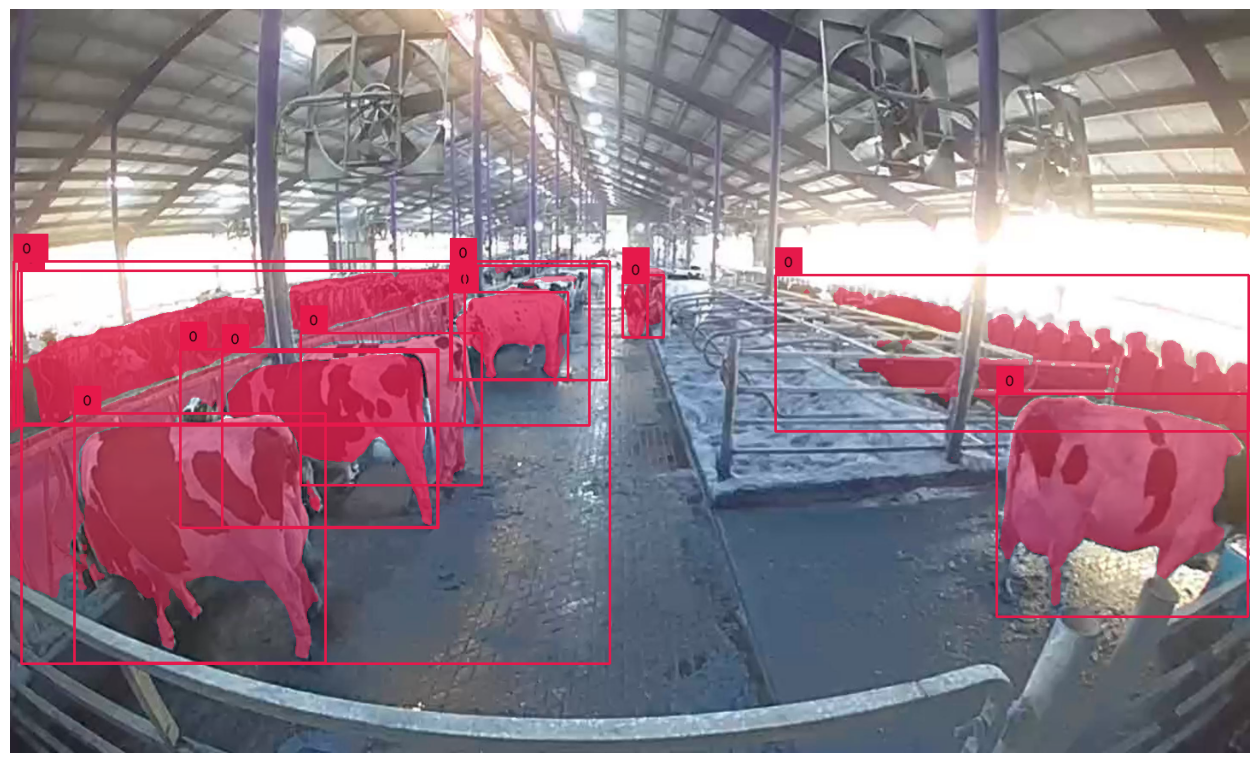

In [22]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
# labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, 
                                         detections=detections, 
                                        #  labels=labels
                                         )

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

## SAM

In [23]:
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [15]:
# about 40 seconds
# crop [0:500, 0:1000] and resize to 1000x2000
img_crop = image_rgb[1000:1600, 1100:1400]
H, W = img_crop.shape[:2]
NEW_H, NEW_W = H * 2, W * 2
img_crop = cv2.resize(img_crop, (NEW_W, NEW_H))
plt.imshow(img_crop)

In [24]:
sam_result = mask_generator.generate(img_crop)

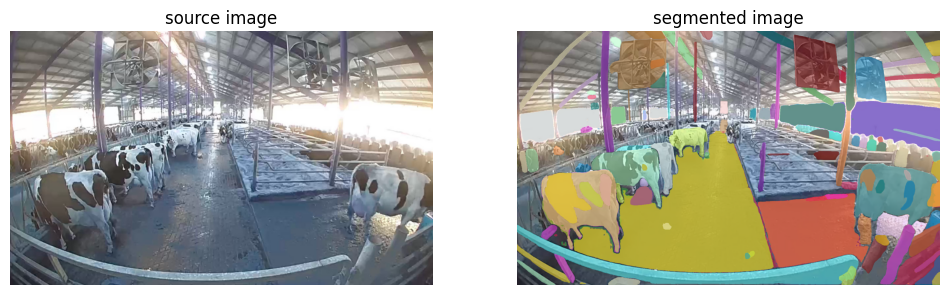

In [25]:
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=img_crop.copy(), detections=detections)

sv.plot_images_grid(
    images=[img_crop, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)